Машинное обучение. Лабораторная работа №1-2. 
Макаренкова В.М., группа М80-306Б-18

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from collections import Counter, namedtuple
from scipy.stats import mode
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import tree


### О датасете 

Датасет взят с сайта www.kaggle.com, он содержит информацию о пациентах и их показателях здоровья, а так же о вероятности сердечного приступа у них, где 0 - низкая вероятность, 1 - высокая вероятность.

In [2]:
ds = pd.read_csv('heart.csv')
ds.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


age - возраст

sex - пол

cp - тип боли в груди

trestbps - артериальное давление в состоянии покоя

chol - холестерин

fbs - больше ли уровень сахара натощак 120 мг/дл

restecg - ЭКГ в покое

thalach - максимальная частота сердцебиения 

exang - наличие стенокардии во время физической нагрузки 

oldpeak - ST-депрессия после нагрузки относительно состояния покоя 

slope - тип наклона

ca - количество крупных сосудов (0-3), окрашенных флурозопией

thal - оценка сердцебиения

target (the predicted attribute) - шанс возникновения сердечного приступа

#### Подготовим данные для дальнейшей работы : проверим пропуски и ошибки и приведем к читабельному виду.

In [3]:
ds.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [4]:
for column in ds.columns:
    print(column)
    print(ds[column].unique())

age
[63 37 41 56 57 44 52 54 48 49 64 58 50 66 43 69 59 42 61 40 71 51 65 53
 46 45 39 47 62 34 35 29 55 60 67 68 74 76 70 38 77]
sex
[1 0]
cp
[3 2 1 0]
trestbps
[145 130 120 140 172 150 110 135 160 105 125 142 155 104 138 128 108 134
 122 115 118 100 124  94 112 102 152 101 132 148 178 129 180 136 126 106
 156 170 146 117 200 165 174 192 144 123 154 114 164]
chol
[233 250 204 236 354 192 294 263 199 168 239 275 266 211 283 219 340 226
 247 234 243 302 212 175 417 197 198 177 273 213 304 232 269 360 308 245
 208 264 321 325 235 257 216 256 231 141 252 201 222 260 182 303 265 309
 186 203 183 220 209 258 227 261 221 205 240 318 298 564 277 214 248 255
 207 223 288 160 394 315 246 244 270 195 196 254 126 313 262 215 193 271
 268 267 210 295 306 178 242 180 228 149 278 253 342 157 286 229 284 224
 206 167 230 335 276 353 225 330 290 172 305 188 282 185 326 274 164 307
 249 341 407 217 174 281 289 322 299 300 293 184 409 259 200 327 237 218
 319 166 311 169 187 176 241 131]
fbs
[1 0]
reste

В датасете нет пропусков, но есть ошибки, удаляем записи с недопустимыми значениями ca и thal

In [5]:
ds.drop([48, 92, 158, 163, 164, 251, 281], inplace = True)


In [6]:
print('ca')
print(ds.ca.unique())
print('thal')
print(ds.thal.unique())

ca
[0 2 1 3]
thal
[1 2 3]


Переименуем колонки для удобства

In [7]:
ds.columns = ['Age', 'Sex', 'Pain type',
              'Blood pressure', 'Cholesterol', 'Blood sugar',
              'ECG', 'Max heart rate', 'Exercise induced angina',
              'ST depression', 'ST slope', 'Number major vessels',
              'Thalassemia', 'Attack']
ds.replace({'Attack':{0:1, 1:0}}, inplace = True)
ds.head()

,Age,Sex,Pain type,Blood pressure,Cholesterol,Blood sugar,ECG,Max heart rate,Exercise induced angina,ST depression,ST slope,Number major vessels,Thalassemia,Attack
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


In [8]:
ds.describe()

,Age,Sex,Pain type,Blood pressure,Cholesterol,Blood sugar,ECG,Max heart rate,Exercise induced angina,ST depression,ST slope,Number major vessels,Thalassemia,Attack
count,296.000000,296.000000,296.000000,296.00000,296.000000,296.00000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,54.523649,0.679054,0.959459,131.60473,247.155405,0.14527,0.523649,149.560811,0.327703,1.059122,1.395270,0.679054,2.327703,0.459459
std,9.059471,0.467631,1.034184,17.72662,51.977011,0.35297,0.526692,22.970792,0.470171,1.166474,0.618235,0.939726,0.585743,0.499198
min,29.000000,0.000000,0.000000,94.00000,126.000000,0.00000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,0.000000,120.00000,211.000000,0.00000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.00000,242.500000,0.00000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,0.000000
75%,61.000000,1.000000,2.000000,140.00000,275.250000,0.00000,1.000000,166.000000,1.000000,1.650000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.00000,564.000000,1.00000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000


Попробуем обнаружить корреляцию

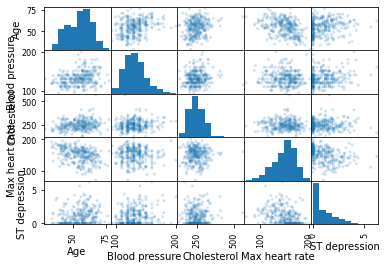

In [9]:
col = ['Age', 'Blood pressure', 'Cholesterol', 'Max heart rate', 'ST depression']        
pd.plotting.scatter_matrix(ds[col], alpha=0.2);

Корреляция между количественными признаками не обнаружена.

### Проанализируем причину сердечных заболеваний.

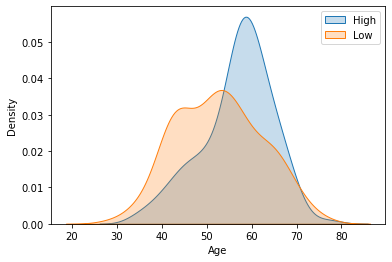

In [10]:
a = sns.kdeplot(ds[ds['Attack'] == 1]['Age'], shade = True)
a = sns.kdeplot(ds[ds['Attack'] == 0]['Age'], shade = True)
a = a.set_xlabel('Age')
a = plt.legend(['High','Low'])

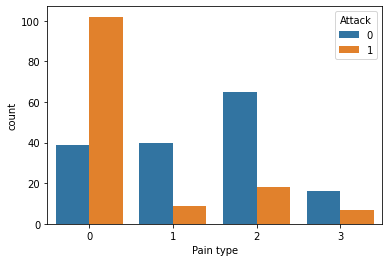

In [11]:
a = sns.countplot(data = ds, x = 'Pain type', hue = 'Attack')

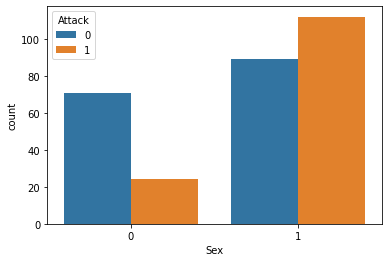

In [12]:
a = sns.countplot(data = ds, x = 'Sex', hue = 'Attack')

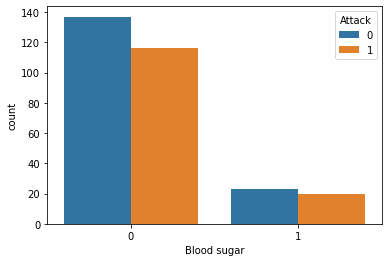

In [13]:
a = sns.countplot(data = ds, x = 'Blood sugar', hue = 'Attack')

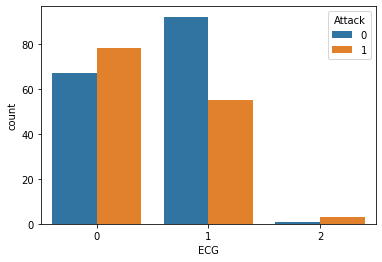

In [14]:
a = sns.countplot(data = ds, x = 'ECG', hue = 'Attack')

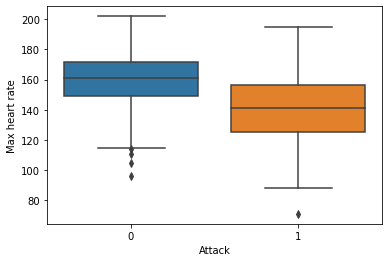

In [15]:
a = sns.boxplot(data = ds, x = 'Attack', y = 'Max heart rate')

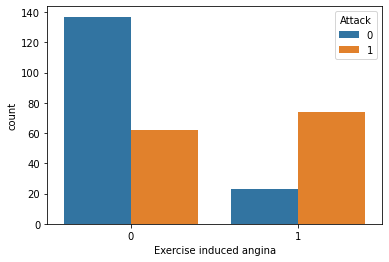

In [16]:
axes = sns.countplot(data = ds, x = 'Exercise induced angina', hue = 'Attack')

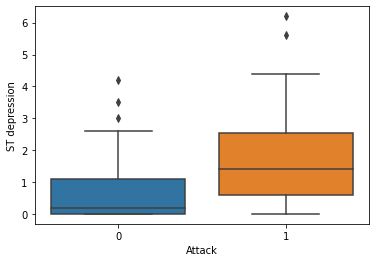

In [17]:
a = sns.boxplot(data = ds, x = 'Attack', y = 'ST depression')

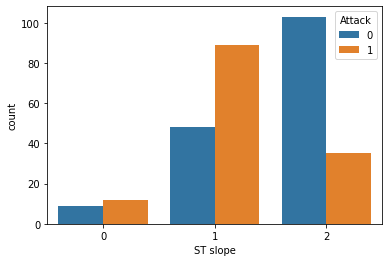

In [18]:
a = sns.countplot(data = ds, x = 'ST slope', hue = 'Attack')

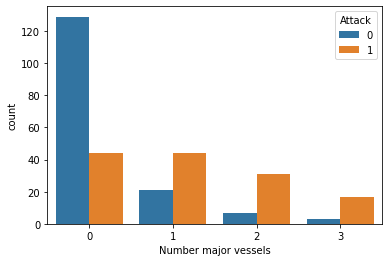

In [19]:
a = sns.countplot(data = ds, x = 'Number major vessels', hue = 'Attack')

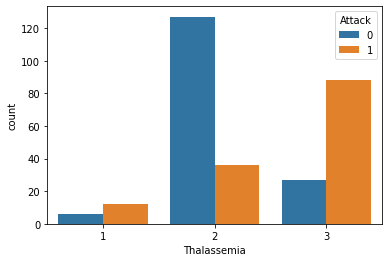

In [20]:
a = sns.countplot(data = ds, x = 'Thalassemia', hue = 'Attack')

### Из представленных графиков можно извлечь следующую информацию:
- Риск сердечного приступа больше всего у людей около 60 лет, преимущественно мужчин

- Сердечный приступ чаще происходит у людей с бессимптомной болью в груди

- Уровень сахара в крови не влияет на возникновение сердечного приступа

- Низкий максимальный пульс - фактор риска

- Вызванная физическими упражнениями стенокардия (Exercise induced angina), высокий уровень ST Depression, ST slope типа Flat и Талассемия обратимого дефекта (Reversible Defect) показывает больше случаев сердечного приступа


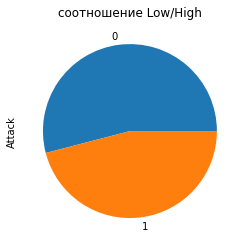

In [21]:
plt.figure()
pd.Series(ds['Attack']).value_counts().sort_index().plot(kind = 'pie')
plt.title('соотношение Low/High');

Датасет не нуждается в балансировке

## Классификация (KNN, Logistic Regression, Naive Bayes Classifier, Decision Tree, Random Forest)

In [22]:
d = ds.reset_index(drop=True)
data = d.sample(frac=1) 

In [60]:
X = data.drop(['Attack'], axis=1)
y = data['Attack']
X1 = data
y1 = data['Attack']
data = data.astype(int)

normalized_df=(data-data.min())/(data.max()-data.min())
df = normalized_df.reset_index(drop=True)
X1 = normalized_df
y1 = normalized_df['Attack']
X2 = df.drop(['Attack'], axis=1)
y2 = df['Attack']

In [24]:
def results(model, X, y, k_folds=5):
    kf = KFold(n_splits=k_folds, random_state=16, shuffle=True)
    scores = np.zeros(k_folds) 
    precisions = np.zeros(k_folds)
    recalls = np.zeros(k_folds)
    for i, (train_index, val_index) in enumerate(kf.split(X, y)):
        X_train, y_train = X.loc[train_index].to_numpy(), y.loc[train_index].to_numpy()
        X_val, y_val = X.loc[val_index].to_numpy(), y.loc[val_index].to_numpy()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        scores[i] = accuracy_score(y_val, y_pred)
        precisions[i] = precision_score(y_val, y_pred)
        recalls[i] = recall_score(y_val, y_pred)
    return (scores, precisions, recalls)

In [25]:
normalized_df.head()

,Age,Sex,Pain type,Blood pressure,Cholesterol,Blood sugar,ECG,Max heart rate,Exercise induced angina,ST depression,ST slope,Number major vessels,Thalassemia,Attack
130,0.270833,1.0,0.333333,0.245283,0.385845,0.0,0.5,0.694656,0.0,0.000000,1.0,0.000000,0.5,0.0
154,0.375000,1.0,0.666667,0.339623,0.289954,0.0,0.5,0.824427,0.0,0.000000,1.0,0.000000,0.5,0.0
16,0.604167,0.0,0.666667,0.245283,0.488584,0.0,0.5,0.770992,0.0,0.000000,1.0,0.000000,0.5,0.0
262,0.520833,1.0,0.000000,0.264151,0.365297,0.0,0.0,0.343511,1.0,0.516129,0.5,0.666667,0.5,1.0
33,0.520833,1.0,0.666667,0.292453,0.335616,0.0,0.0,0.618321,0.0,0.080645,0.0,0.333333,0.5,0.0


### KNN-метод 

In [26]:
class KNN():
    def __init__(self, nn=5):
        self.nn = nn
    def dists(self, X):
        num_test = X.shape[0]
        num_train = self.X.shape[0]
        t = np.dot(X, self.X.T)
        dists = np.sqrt(-2 * t + np.square(self.X).sum(1) +
        np.matrix(np.square(X).sum(1)).T)
        return dists
    def fit(self, X, y):  
        self.X = X
        self.y = y
    def predict(self, X):
        dists = self.dists(X)
        preds = np.zeros(dists.shape[0])
        for i in range(dists.shape[0]):
            labels = self.y[np.argsort(dists[i, :])].flatten()
            top_nn_y = labels[:self.nn]
            preds[i] = Counter(top_nn_y).most_common(1)[0][0]
        return preds

### Байесовский классификатор 

In [27]:
class NormalDistribution:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def probability_d(self, value):
        return 1 / (self.std * (2 * np.pi) ** 0.5 * np.exp((value - self.mean) ** 2 / (2 * self.std ** 2)))

In [28]:
class NBC:

    def __inint__(self):
      ...

    def fit(self, design_matrix, target):
        target=np.array(target)
        self.label_prob = {
            0: len(target[target == 0]) / len(target),
            1: len(target[target == 1]) / len(target)
        }
        self.cond_prob = {}
        for v in (0, 1):
            prob = []
            for column in range(design_matrix.shape[1]):
                feature = design_matrix[target == v, column]
                prob.append(NormalDistribution(feature.mean(axis=0), feature.std(axis=0)))
            self.cond_prob[v] = prob
    
    def predict(self, array):
        label_prob = {}
        res=[]
        for j in range(len(array)):
          for v in {0, 1}:
              cond_feature_prob = 0
              for i in range(10):
                  cond_feature_prob += np.log(self.cond_prob[v][i].probability_d(array[j][i]))
              label_prob[v] = cond_feature_prob + np.log(self.label_prob[v])
           
          res.append(0 if label_prob[1] < label_prob[0] else 1)
        return res

### Логистическая регрессия

In [29]:
class LR():
    def __init__(self, lr=0.01, steps=5000):
        self.lr = lr
        self.steps = steps

    def s(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.coefs = np.zeros(X.shape[1])

        for _ in range(self.steps):
            h = self.s(np.dot(X, self.coefs))
            self.coefs -= self.lr * \
                          np.dot(X.T, (h - y)) / y.size

    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return self.s(np.dot(X, self.coefs)).round()


### Дерево решений

In [30]:
class Node():
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

In [31]:
class DT():
    def __init__(self, max_depth=1, rf=False):
        self.max_depth = max_depth
        self.rf = rf
    def fit(self, X, y, max_features=None):
        self.n_classes_ = len(set(y))
        if not self.rf:
            n_features_ = X.shape[1]
        else:
            ind = np.random.choice(X.shape[0], X.shape[0])
            X, y = X[tuple([ind])], y[tuple([ind])]
            if max_features is None:
                n_features_ = np.sqrt(X.shape[1]).astype(int)
            else:
                n_features_ = max_features
        self.features_ = np.sort(np.random.choice(X.shape[1], n_features_,
                                                  replace=False))
        self.tree_ = self._grow_tree(X, y)
                
    def predict(self, X):
        return [self._predict(inputs) for inputs in X]
    
    def _best_split(self, X, y):
        m = y.size
        if m <= 1:
            return None, None
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None
        for idx in self.features_:
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )
                gini = (i * gini_left + (m - i) * gini_right) / m
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr
    
    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i)
                                 for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(predicted_class=predicted_class)
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

### Random forest

In [72]:
class RF:
    
    def __init__(self, n_estimators=2, bootstrap=0.5):
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.forest = []
    
    
    def fit(self, Xl, yl):
        X = np.array(Xl)
        y = np.array(yl)
        self.forest = []
        n_samples = len(y)
        n_sub_samples = round(n_samples*self.bootstrap)
        
        for i in range(self.n_estimators):
            X_subset = X[:n_sub_samples]
            y_subset = y[:n_sub_samples]
            
            tree_ = tree.DecisionTreeClassifier(max_depth=2)
            tree_.fit(X_subset, y_subset)
            self.forest.append(tree_)
        return self
    
    
    def predict(self, X):
        n_samples = X.shape[0]
        n_trees = len(self.forest)
        predictions = np.empty([n_trees, n_samples])
        for i in range(n_trees):
            predictions[i] = self.forest[i].predict(X)
        
        return mode(predictions)[0][0]
    
    
    def score(self, Xl, yl):
        X = np.array(Xl)
        y = np.array(yl)
        y_predict = self.predict(X)
        n_samples = len(y)
        correct = 0
        for i in range(n_samples):
            if y_predict[i] == y[i]:
                correct = correct + 1
        accuracy = correct/n_samples
        return accuracy

## Сравнение результатов с sklearn

In [62]:
%%time
model = KNN(nn=5)
values = results(model, X2, y2)
print("My KNN accuracy: ", values[0].mean())
print("Precision: ", values[1].mean())
print("Recall: ", values[2].mean())

My KNN accuracy:  0.7972316384180791
Precision:  0.7868981937602626
Recall:  0.762909090909091
CPU times: user 93.1 ms, sys: 5.43 ms, total: 98.5 ms
Wall time: 54 ms


In [63]:
%%time
model = KNeighborsClassifier(n_neighbors=5)
values = results(model, X2, y2)
print("Sklearn accuracy: ", values[0].mean())
print("Precision: ", values[1].mean())
print("Recall: ", values[2].mean())

Sklearn accuracy:  0.7972316384180791
Precision:  0.7868981937602626
Recall:  0.762909090909091
CPU times: user 54.2 ms, sys: 8.11 ms, total: 62.3 ms
Wall time: 62 ms


И реализованный и библиотечный алгоритм показали хорошую точность 

In [64]:
%%time
model = NBC()
values = results(model, X2, y2)
print("My Naive Bayes Classifier accuracy: ", values[0].mean())
print("Precision: ", values[1].mean())
print("Recall: ", values[2].mean())

My Naive Bayes Classifier accuracy:  0.7973446327683615
Precision:  0.8113952713952715
Recall:  0.7263549783549784
CPU times: user 75.3 ms, sys: 5.49 ms, total: 80.8 ms
Wall time: 81.4 ms


In [65]:
%%time
model = GaussianNB()
values = results(model, X2, y2)
print("Sklearn Naive Bayes Classifier accuracy: ", values[0].mean())
print("Precision: ", values[1].mean())
print("Recall: ", values[2].mean())

Sklearn Naive Bayes Classifier accuracy:  0.8310169491525425
Precision:  0.8443345543345544
Recall:  0.7754285714285716
CPU times: user 43.1 ms, sys: 4.76 ms, total: 47.9 ms
Wall time: 46.8 ms


Собственная реализация алгоритма байесовского классифакатора выдает практически такую же точность, что и в sklearn, но оказалась более медленной

In [66]:
%%time
model = LR()
values = results(model, X2, y2)
print("My Logistic Regression Accuracy: ", values[0].mean())
print("Precision: ", values[1].mean())
print("Recall: ", values[2].mean())

My Logistic Regression Accuracy:  0.8310734463276838
Precision:  0.8474501424501424
Recall:  0.7845541125541126
CPU times: user 368 ms, sys: 5.92 ms, total: 374 ms
Wall time: 375 ms


In [67]:
%%time
model = LogisticRegression()
values = results(model, X2, y2)
print("Sklearn Logistic Regression Accuracy: ", values[0].mean())
print("Precision: ", values[1].mean())
print("Recall: ", values[2].mean())

Sklearn Logistic Regression Accuracy:  0.8344067796610171
Precision:  0.862983682983683
Recall:  0.7750303030303031
CPU times: user 135 ms, sys: 8.37 ms, total: 143 ms
Wall time: 80.6 ms


Результаты по точности так же практически одинаковые, собственная реализация заметно медленнее

In [68]:
%%time
model = DT()
values = results(model, X, y)
print("My Decision Tree Accuracy: ", values[0].mean())
print("Precision: ", values[1].mean())
print("Recall: ", values[2].mean())

My Decision Tree Accuracy:  0.7263841807909603
Precision:  0.7157154467499296
Recall:  0.6693254566783978
CPU times: user 113 ms, sys: 5.33 ms, total: 118 ms
Wall time: 116 ms


In [69]:
%%time
model = DecisionTreeClassifier(max_depth=3)
values = results(model, X, y)
print("Sklearn Decision Tree Accuracy: ", values[0].mean())
print("Precision: ", values[1].mean())
print("Recall: ", values[2].mean())

Sklearn Decision Tree Accuracy:  0.8005084745762712
Precision:  0.820267475349145
Recall:  0.7230030165912518
CPU times: user 42 ms, sys: 4.24 ms, total: 46.3 ms
Wall time: 45 ms


Библиотечная реализация оказалась точнее и быстрее

In [73]:

model = RF()
values = results(model, X2, y2)
print("My Random Forest Accuracy: ", values[0].mean())
print("Precision: ", values[1].mean())
print("Recall: ", values[2].mean())

My Random Forest Accuracy:  0.7031073446327685
Precision:  0.7765350877192982
Recall:  0.4819220779220779


In [71]:
model = RandomForestClassifier()
values = results(model, X2, y2)
print("Sklearn Random Forest Accuracy: ", values[0].mean())
print("Precision: ", values[1].mean())
print("Recall: ", values[2].mean())

Sklearn Random Forest Accuracy:  0.8142372881355933
Precision:  0.8118602150537635
Recall:  0.7807445887445887


Sklearn заметно превосходит реализацию

##### Sklearn по тем или иным пунктам превосходит реализованные классификаторы, но отставание по точности почти во всех случаях минимально, для ликвидации отставания по времени нужна оптимизация